In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interp
%matplotlib inline

# Set random seed to ensure reproducability
random_state = 42

In [5]:
# Column names extracted from the dataset description file
cols = ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology", 
         "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways", 
         "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm", 
         "Horizontal_Distance_To_Fire_Points"] + \
       ["Wilderness_Area_{}".format(i) for i in range(4)] + \
       ["Soil_Type {}".format(i) for i in range(40)] + \
       ["Cover_Type"]

In [6]:
data = pd.read_csv('dataset/covtype.data', header=None, names=cols)

# Data preparation
- **subsample the data to 10k samples**

In [7]:
class_size = 10000
df = data.groupby("Cover_Type").apply(lambda x: x.sample(min(class_size, len(x)))).reset_index(1)
df = df.drop(columns=["Cover_Type"]).reset_index().drop(columns=["level_1"])

X = df.loc[:, df.columns != 'Cover_Type']
y = df[["Cover_Type"]]

### Get the binary columns

In [9]:
binary_columns = df.columns[df.columns.map(lambda x: ("Area" in x) or ("Soil" in x))]
binX = X.loc[:, binary_columns]

### Get the numeric columns

In [10]:
numeric_columns = ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology", 
         "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways", 
         "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm", 
         "Horizontal_Distance_To_Fire_Points"]
numX = X.loc[:, numeric_columns]
numX = pd.concat([numX, y], axis=1)

In [11]:
dumX = pd.DataFrame()

for col in numX:
    cutdf = pd.cut(numX[col], 3, labels=[0, 1, 2])
    dummydf = pd.get_dummies(cutdf)
    seriesname = dummydf.columns.name
    dummydf.columns = [seriesname + "_low", seriesname + "_mid", seriesname + "_high"]
    dumX = pd.concat([dumX, dummydf], axis=1)

In [13]:
print("Shape of the dummyfied dataset:", dumX.shape)
print("Shape of the binary dataset: ", binX.shape)

Shape of the dummyfied dataset: (62240, 33)
Shape of the binary dataset:  (62240, 44)


In [14]:
allX = pd.concat([dumX, binX], axis=1)

# Unsupervised learning

## Association rules

In [45]:
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import LabelBinarizer

frequent_itemsets = {}
minpaterns = 1000
minsup = 0.9
classrules = None
while minsup > 0:    
    minsup = minsup * 0.9
    frequent_itemsets = apriori(allX, min_support=minsup, use_colnames=True, verbose=3)
    
    if len(frequent_itemsets) < 1:
        continue
    
    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
    classrules = rules[rules['consequents'] == {'Cover_Type'}]
    
    print("Minsup {} found {} patterns out of which {} contain class consequent"
          .format(minsup, len(frequent_itemsets), len(classrules)))  
    
    if len(classrules) >= 100:
        print("Found {} rules which have Cover_Type as consequent.".format(len(classrules)))
        break;
    
    if len(frequent_itemsets) >= minpaterns:
        print("Minimum support:", minsup)
        print("Number of found patterns:", len(frequent_itemsets))
        break

Processing 6 combinations | Sampling itemset size 2
Minsup 0.81 found 3 patterns out of which 0 contain class consequent
Processing 15 combinations | Sampling itemset size 3
Minsup 0.7290000000000001 found 14 patterns out of which 0 contain class consequent
Processing 4 combinations | Sampling itemset size 43
Minsup 0.6561000000000001 found 23 patterns out of which 0 contain class consequent
Processing 48 combinations | Sampling itemset size 43
Minsup 0.5904900000000002 found 44 patterns out of which 0 contain class consequent
Processing 60 combinations | Sampling itemset size 54
Minsup 0.5314410000000002 found 67 patterns out of which 0 contain class consequent
Processing 105 combinations | Sampling itemset size 5
Minsup 0.47829690000000014 found 100 patterns out of which 0 contain class consequent
Processing 36 combinations | Sampling itemset size 65
Minsup 0.43046721000000016 found 146 patterns out of which 0 contain class consequent
Processing 7 combinations | Sampling itemset size

$$\text{Workflow of getting the rules into }\LaTeX$$
1. Generate this csv as shown below
2. Copy it to the https://www.tablesgenerator.com/latex_tables and under File->Paste table data paste the data
3. Copy the data to the Latex
4. Replace "-" with \\ to do the line breaks
5. Style the table and resize it correctly

In [46]:
select = rules
select = select.sort_values(by=["confidence", "support", "leverage"], ascending=False)\
    [["antecedents", "consequents", "confidence", "support", "leverage"]].head(5).round(3)

select = select.rename(columns={"confidence": "conf", "support": "supp", "leverage": "lever"})
print(select.to_csv(index=False, sep=";").replace("frozenset({", "").replace("})", "").replace("'", "")\
     .replace(", ", "-"))

antecedents;consequents;conf;supp;lever
Aspect_low-Hillshade_Noon_high;Hillshade_9am_high;1.0;0.379;0.041
Aspect_low-Slope_low;Hillshade_9am_high;1.0;0.368;0.04
Aspect_low-Slope_low-Hillshade_Noon_high;Hillshade_9am_high;1.0;0.358;0.039
Aspect_low-Hillshade_3pm_mid-Slope_low;Hillshade_9am_high;1.0;0.34;0.037
Aspect_low-Hillshade_3pm_mid-Hillshade_Noon_high;Hillshade_9am_high;1.0;0.333;0.036



## Clustering
- include the silhouette analysis
- whatever score
- contingency matrix

### Subsample the data even more

In [19]:
class_size = 2000
df = data.groupby("Cover_Type").apply(lambda x: x.sample(min(class_size, len(x)))).reset_index(1)
df = df.drop(columns=["Cover_Type"]).reset_index().drop(columns=["level_1"])

X = df.loc[:, df.columns != 'Cover_Type']
y = df[["Cover_Type"]]

### Standardize the data
>Standardizing data is recommended because otherwise the range of values in each feature will act as a weight when determining how to cluster data, which is typically undesired.

**Should I standardize the binary attribs as well?**

In [31]:
from sklearn.preprocessing import StandardScaler

X_s = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

### Dendrogram

In [45]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans

def dendrogram_plot(data, link="single"):
    linkageMatrix = linkage(data, link)

    plt.xlabel('point index')
    plt.ylabel('distance')
    dendrogram(linkageMatrix, truncate_mode='lastp', p=24,
        leaf_rotation=90., leaf_font_size=8.)
    
def elbow_plot(data):
    inertia = []
    for i in range(1,25):
        kmeans = KMeans(n_clusters=i, random_state=420)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)

    # Plot the elbow graph
    plt.plot(range(1,25), inertia)
    plt.xlabel("k")
    plt.ylabel('utility function')
    return plt

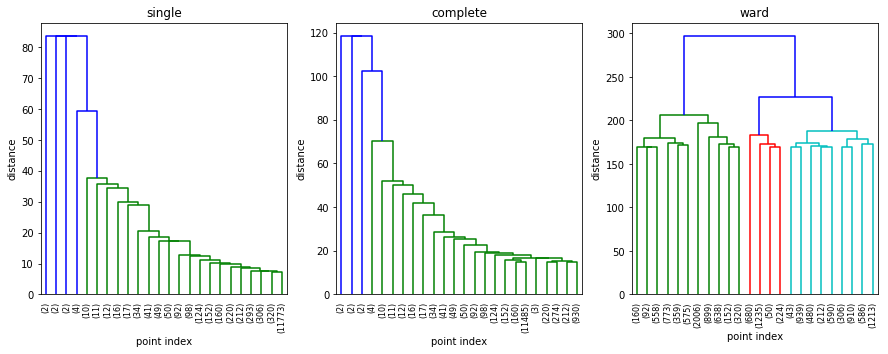

In [39]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("single")
dendrogram_plot(X_s, "single")
plt.subplot(1, 3, 2)
plt.title("complete")
dendrogram_plot(X_s, "complete")
plt.subplot(1, 3, 3)
plt.title("ward")
dendrogram_plot(X_s, "ward")
plt.show()

In [44]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

cm = matplotlib.cm.get_cmap("Accent")

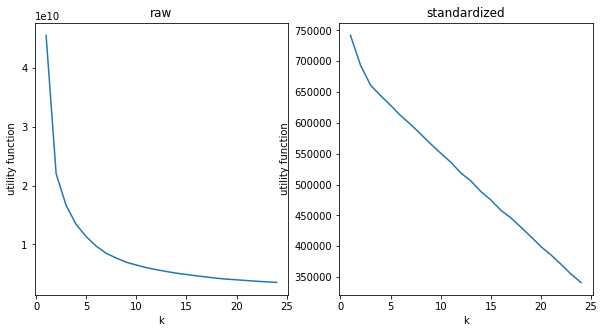

In [50]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("raw")
elbow1 = elbow_plot(X)
plt.subplot(1, 2, 2)
plt.title("standardized")
elbow2 = elbow_plot(X_s)
plt.show()

**Silhouette score**
> The silhouette_score gives the average value for all the samples. This gives a perspective into the density and separation of the formed clusters.

#### Aglomerative clustering

In [74]:
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import itertools

searchspace = {"linkage_type": ["single", "complete", "ward", "average"],
               "clust_count": np.arange(3, 8, 1),
               "dataset_name": ["X", "X_s"]}

results = []

for comb in itertools.product(*searchspace.values()):
    linktype = comb[0]
    clustcount = comb[1]
    dataset_name = comb[2]
    
    if dataset_name == "X":
        dataset = X
    else:
        dataset = X_s
    
    linkageMatrix = linkage(dataset, linktype)
    clusters = fcluster(linkageMatrix, clustcount, criterion='maxclust')
    clustered = X_s.copy()
    clustered["cluster"] = clusters
    
    score = silhouette_score(X_s, clusters)
    results.append([score, comb])
    
    print("Linktype", linktype, "clustcount", clustcount, "dataset", dataset_name)
    print("Silhouette score", score)

Linktype single clustcount 3 dataset X
Silhouette score 0.16834746081129448
Linktype single clustcount 3 dataset X_s
Silhouette score 0.8899347137470182
Linktype single clustcount 4 dataset X
Silhouette score 0.1406251031486247
Linktype single clustcount 4 dataset X_s
Silhouette score 0.8901599481180196
Linktype single clustcount 5 dataset X
Silhouette score 0.12973455397184497
Linktype single clustcount 5 dataset X_s
Silhouette score 0.845904760500038
Linktype single clustcount 6 dataset X
Silhouette score 0.11300611650574287
Linktype single clustcount 6 dataset X_s
Silhouette score 0.7618636952182913
Linktype single clustcount 7 dataset X
Silhouette score 0.11168165462223374
Linktype single clustcount 7 dataset X_s
Silhouette score 0.7510295707360342
Linktype complete clustcount 3 dataset X
Silhouette score 0.09245234524802262
Linktype complete clustcount 3 dataset X_s
Silhouette score 0.8899910915692779
Linktype complete clustcount 4 dataset X
Silhouette score 0.09216132344830502
Li

In [86]:
linkageMatrix = linkage(X_s, "ward")
clusters = fcluster(linkageMatrix, 3, criterion='maxclust')
clustered = X_s.copy()
clustered["cluster"] = clusters

colors = cm(np.linspace(0, 1, len(np.unique(clusters))))

transformed = PCA(n_components=2).fit_transform(clustered.drop(columns=["cluster"]))
transformed = pd.DataFrame(transformed, columns=["x", "y"])

transformed["class"] = y.values
transformed["cluster"] = clusters
transformed["color"] = transformed.cluster.apply(lambda x: colors[x-1])

In [87]:
np.unique(clusters, return_counts=True)

(array([1, 2, 3], dtype=int32), array([6532, 2189, 5279]))

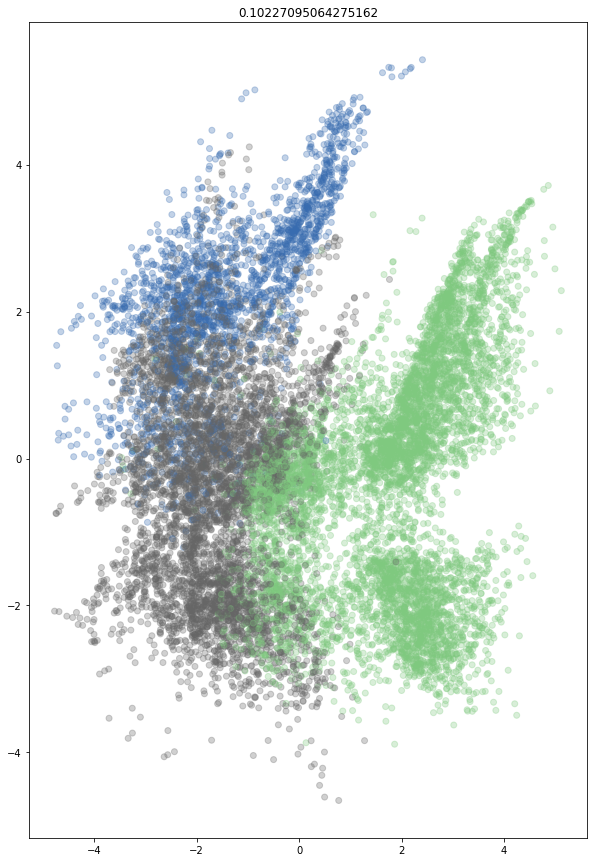

In [88]:
plt.figure(figsize=(10, 15))
plt.title(silhouette_score(X_s, clusters))
plt.scatter(transformed.x, transformed.y, c=transformed.color, alpha=0.3)
plt.show()

#### KMeans clustering

In [113]:
clusters = KMeans(n_clusters=7, init='k-means++', random_state=420).fit_predict(X_s)
transformed = PCA(n_components=2).fit_transform(X_s)

colors = cm(np.linspace(0, 1, len(np.unique(clusters))))
transformed = pd.DataFrame(transformed, columns=["x", "y"])
transformed["class"] = y.values
transformed["cluster"] = clusters
transformed["color"] = transformed.cluster.apply(lambda x: colors[x-1])

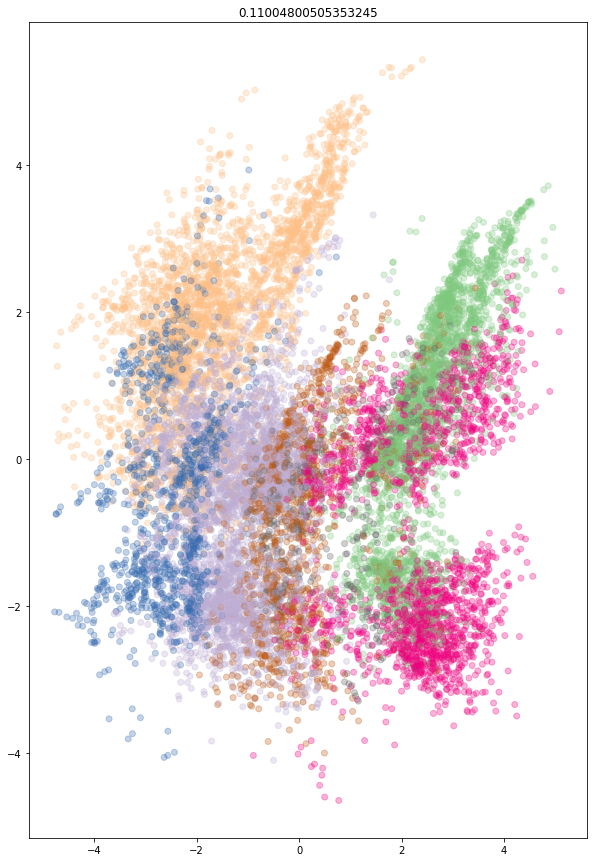

In [115]:
plt.figure(figsize=(10, 15))
plt.title(silhouette_score(X_s, clusters))
plt.scatter(transformed.x, transformed.y, c=transformed.color, alpha=0.3)
plt.show()